# Rianna's ML models

In [7]:
# import data
import pickle
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## ML Models

### Method: XGBoost

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [9]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.001,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="rmse",
    early_stopping_rounds=10,
    n_jobs=-1
)

In [10]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.savefig("XGB Regressor Train and Validation RMSE Scores")

Fold 1 — MSE: 0.0797
Fold 2 — MSE: 0.0810
Fold 3 — MSE: 0.0804
Fold 4 — MSE: 0.0806
Fold 5 — MSE: 0.0807
Average MSE: 0.0805 ± 0.0004


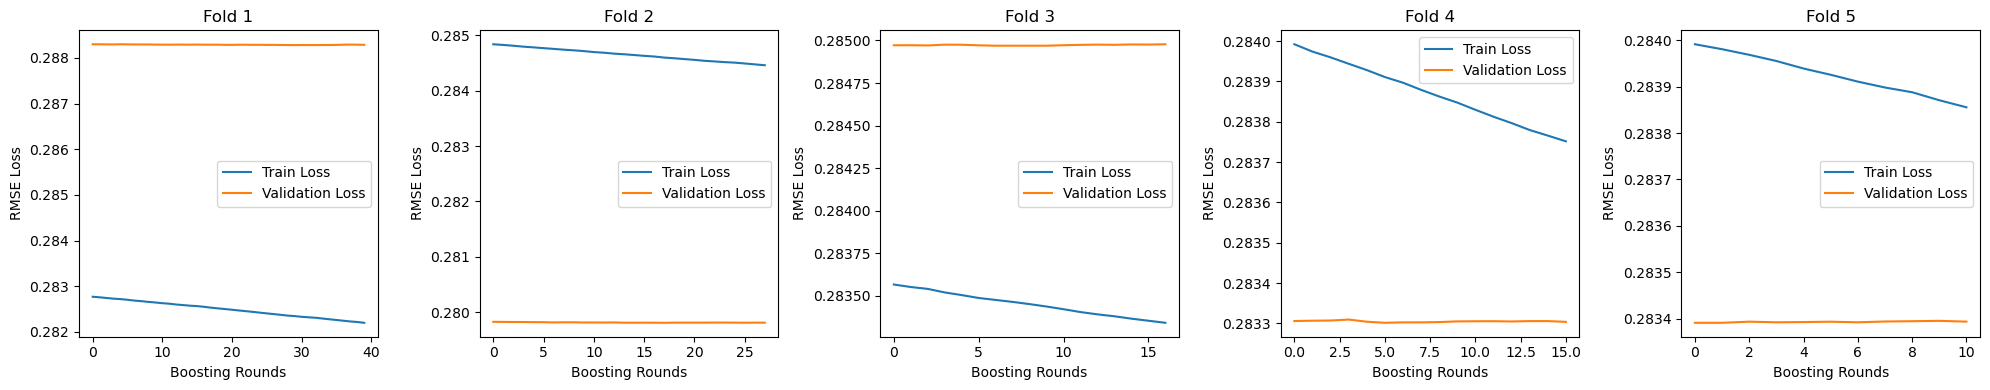

In [11]:
# 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_mse_scores = []
val_mse_scores = []
eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_in, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_in, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_model.fit(
        X_train_in,
        y_train_in,
        eval_set=[(X_train_in, y_train_in), (X_val, y_val)],
        verbose=False,
    )

    evals_result = xgb_model.evals_result()
    eval_scores.append(evals_result)

    y_train_pred = xgb_model.predict(X_train_in)
    y_val_pred = xgb_model.predict(X_val)

    train_mse = mean_squared_error(y_train_in, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    train_mse_scores.append(train_mse)
    val_mse_scores.append(val_mse)

    print(f"Fold {fold + 1} — MSE: {train_mse:.4f}")

plot_train_val_losses(eval_scores)

print(f"Average MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")

In [12]:
# Evaluate test data
xgb_model.early_stopping_rounds = None
xgb_model.fit(X_train, y_train) # Re-fit on all training data
y_test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

Final Test MSE: 0.0814
Final Test R²: -0.0001


To do for XGBoost:
- hyperparameter tuning by grid search or randomized search

### Regularization strategies and hyperparameter tuning

### Production mode

### Final Results